In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import common
import xgboost as xgb

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

print(f"pandas-version: {pd.__version__}")
print(f"polars-version: {pl.__version__}")

pandas-version: 2.2.0
polars-version: 0.20.6


In [2]:
READ_ORIGINS="/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"
REF_MAP_PATH="/storage2/tbrekalo/HG002-simulated/chr19-ref.paf"
CHAINS_PATH="/home/tbrekalo/dev/tb-ram/dev-data/HG002/chr19-sim-sample-chain.tsv"

In [3]:
df_ovlps = common.load_paf_df(REF_MAP_PATH)
df_chains = common.load_chains_df(CHAINS_PATH)
df_origins = common.load_origins_df(READ_ORIGINS)

In [4]:
df_chain_ovlps = common.create_annotated_overlaps_from_chains(
    df_chains,
    df_origins,
)

In [5]:
df_chain_ovlps

chain-id,query-name,query-start,query-end,strand,target-name,target-start,target-end,origin-strand,origin-start,origin-end,ratio
i64,str,i64,i64,str,str,i64,i64,str,i64,i64,f64
0,"""S1_12271_chr19…",315,1066,"""-""","""chr19_MATERNAL…",9557288,9558007,"""+""",22830962,22852123,0.0
1,"""S1_12271_chr19…",1065,5215,"""-""","""chr19_MATERNAL…",9829390,9834104,"""+""",22830962,22852123,0.0
2,"""S1_12271_chr19…",12328,13205,"""-""","""chr19_MATERNAL…",9869813,9870687,"""+""",22830962,22852123,0.0
3,"""S1_12271_chr19…",12331,13205,"""-""","""chr19_MATERNAL…",9976962,9977877,"""+""",22830962,22852123,0.0
4,"""S1_12271_chr19…",193,2577,"""-""","""chr19_MATERNAL…",10223826,10226471,"""+""",22830962,22852123,0.0
5,"""S1_12271_chr19…",12239,13096,"""-""","""chr19_MATERNAL…",11870736,11871207,"""+""",22830962,22852123,0.0
6,"""S1_12271_chr19…",6570,7416,"""-""","""chr19_MATERNAL…",12426301,12427146,"""+""",22830962,22852123,0.0
7,"""S1_12271_chr19…",12359,13277,"""-""","""chr19_MATERNAL…",12426301,12427207,"""+""",22830962,22852123,0.0
8,"""S1_12271_chr19…",6196,6532,"""-""","""chr19_MATERNAL…",20274857,20275152,"""+""",22830962,22852123,0.0


In [6]:
df_chains_detail = df_chains.join(
    df_chain_ovlps.select(
        "chain-id",
        "query-start",
        "query-end",
        "target-start",
        "target-end",
        "ratio",
    ),
    on="chain-id",
    how="left",
)

In [7]:
df_model = df_chains_detail.group_by(
    "chain-id",
).agg(
    pl.col("query-start").first(),
    pl.col("query-end").first(),
    pl.col("query-matches").first(),
    pl.col("target-start").first(),
    pl.col("target-end").first(),
    pl.col("target-matches").first(),
    pl.col("ratio").first()
).top_k(2_000, by="ratio")

In [8]:
df_model.select(
    (pl.col("ratio") >= 0.99).sum().alias("true-positive"),
    (pl.col("ratio") < 0.99).sum().alias("true-negative"),
)

true-positive,true-negative
u32,u32
1037,963


In [9]:
X = df_model.select([
    "query-start", "query-end", "query-matches",
    "target-start", "target-end", "target-matches",
]).to_pandas()

Y = df_model.select(
    (
        pl.col("ratio") >= 0.99
    ).cast(pl.Int64)
).to_pandas()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42,
)

In [11]:
models = {
    "logistic-regression": LogisticRegression(),
    "std-svc": make_pipeline(StandardScaler(), SVC(gamma="auto")),
    "xgb-classifier": xgb.XGBClassifier(
        objective="binary:logistic",
        grow_policy="lossguide",
        random_state=42,
    ),
}

In [12]:
for model in models.values():
    model.fit(X_train, y_train)

/home/tbrekalo/dev/tb-ram/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tbrekalo/dev/tb-ram/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tbrekalo/dev/tb-ram/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

In [13]:
df_report = pl.DataFrame(schema={"model": str, "class": pl.Int64, "metric": str, "value": pl.Float64})
for name, model in models.items():
    y_pred = model.predict(X_test)
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_report = pl.concat([
        df_report,
        pl.DataFrame(
            pd.melt(
                pd.DataFrame(report)[["0", "1"]].transpose()[["precision", "recall", "f1-score"]].reset_index(), 
                id_vars=["index"],
                var_name="metric",
            )[["index", "metric", "value"]]
        ).select(
            pl.lit(name).alias("model"),
            pl.col("index").alias("class").cast(pl.Int64),
            pl.col("metric"),
            pl.col("value"),
        ),
    ])

df_report

model,class,metric,value
str,i64,str,f64
"""logistic-regre…",0,"""precision""",0.985348
"""logistic-regre…",1,"""precision""",0.93578
"""logistic-regre…",0,"""recall""",0.927586
"""logistic-regre…",1,"""recall""",0.987097
"""logistic-regre…",0,"""f1-score""",0.955595
"""logistic-regre…",1,"""f1-score""",0.960754
"""std-svc""",0,"""precision""",0.985348
"""std-svc""",1,"""precision""",0.93578
"""std-svc""",0,"""recall""",0.927586


<Figure size 640x480 with 0 Axes>

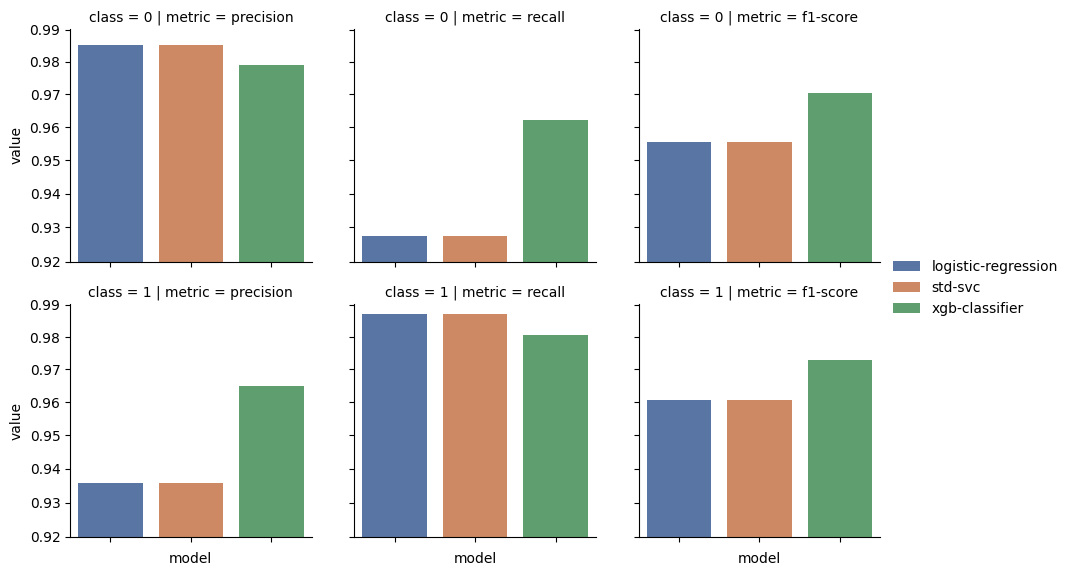

In [19]:
plt.tight_layout()
g = sns.FacetGrid(df_report.to_pandas(), row="class", col="metric")
g.map_dataframe(
    sns.barplot, 
    x="model",
    y="value",
    hue="model",
    palette="deep",
    legend=True,
).set(yscale = "log")

g.set_xlabels()
g.set_xticklabels([])

min_val = np.round(df_report["value"].min() - 0.01, 2)
max_val = np.round(df_report["value"].max() + 0.01, 2)
g.set(
    yticks=np.arange(min_val, max_val, 0.01),
    yticklabels=[np.round(x, 2) for x in np.arange(min_val, max_val, 0.01)],
)
g.add_legend()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

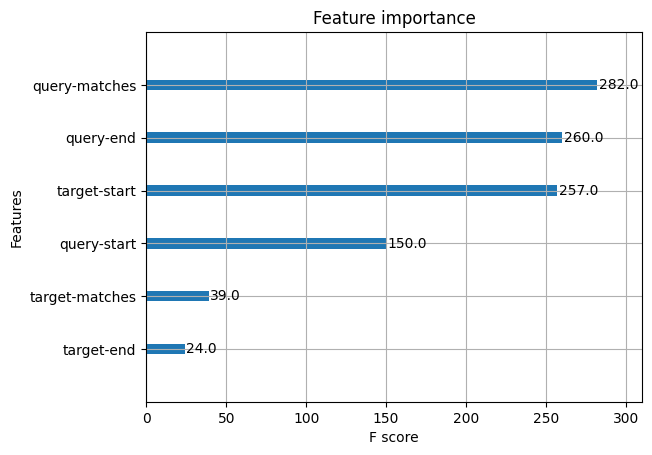

In [16]:
xgb.plot_importance(models["xgb-classifier"])